In [85]:
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import os
import pandas as pd
import re

In [86]:
def to_k(y, pos):
  return '%1.0fk' % (y * 1e-3)

In [87]:
datasets = ['books', 'history', 'fb', 'osm']
# colors = ['#4E79A7', '#F28E2B', '#59A14F', '#E15759']
colors = ['red', 'orange', 'green', 'blue']

build_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'build')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

/tmp/ipykernel_1212402/429764250.py:7: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, header=None)
/tmp/ipykernel_1212402/429764250.py:7: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, header=None)
/tmp/ipykernel_1212402/429764250.py:7: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, header=None)
/tmp/ipykernel_1212402/429764250.py:7: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, header=None)


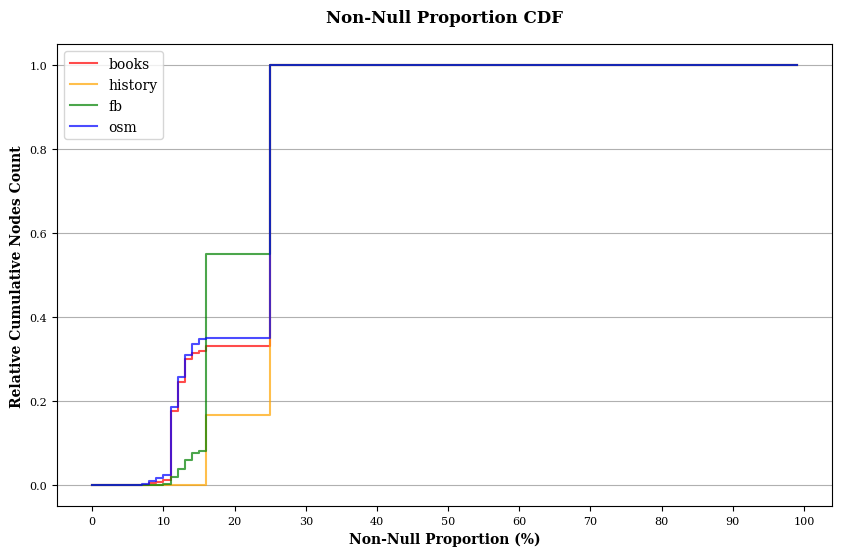

In [88]:
csv_file_names = [os.path.join(build_path, f'{dataset}.csv') for dataset in datasets]

plt.figure(figsize=(10, 6))

for i, file_name in enumerate(csv_file_names):
    try:
      df = pd.read_csv(file_name, header=None)
    except Exception as e:
      continue

    total_count = len(df)
    total_values = df.iloc[2:, 0].astype(float)
    null_values = df.iloc[2:, 1].astype(float)
    non_null_percentages = ((total_values - null_values) / total_values) * 100
    percent_intervals = np.arange(0, 101, 1)
    counts, _ = np.histogram(non_null_percentages, bins=percent_intervals)
    counts = np.asarray(counts) / total_count
    cumulative_counts = np.cumsum(counts)

    plt.plot(percent_intervals[:-1], cumulative_counts,
             drawstyle='steps-post', color=colors[i % len(colors)], alpha=0.7, label=file_name.split('/')[-1].split('.')[0])

plt.xlabel('Non-Null Proportion (%)', fontdict={'weight': 'bold'})
plt.ylabel('Relative Cumulative Nodes Count', fontdict={'weight': 'bold'})
plt.xticks(np.arange(0, 101, 10), size=8)
plt.yticks(size=8)
plt.grid(axis='y')
plt.legend()
plt.title('Non-Null Proportion CDF', fontdict={'size': 12, 'weight': 'bold'}, pad=16)
plt.show()

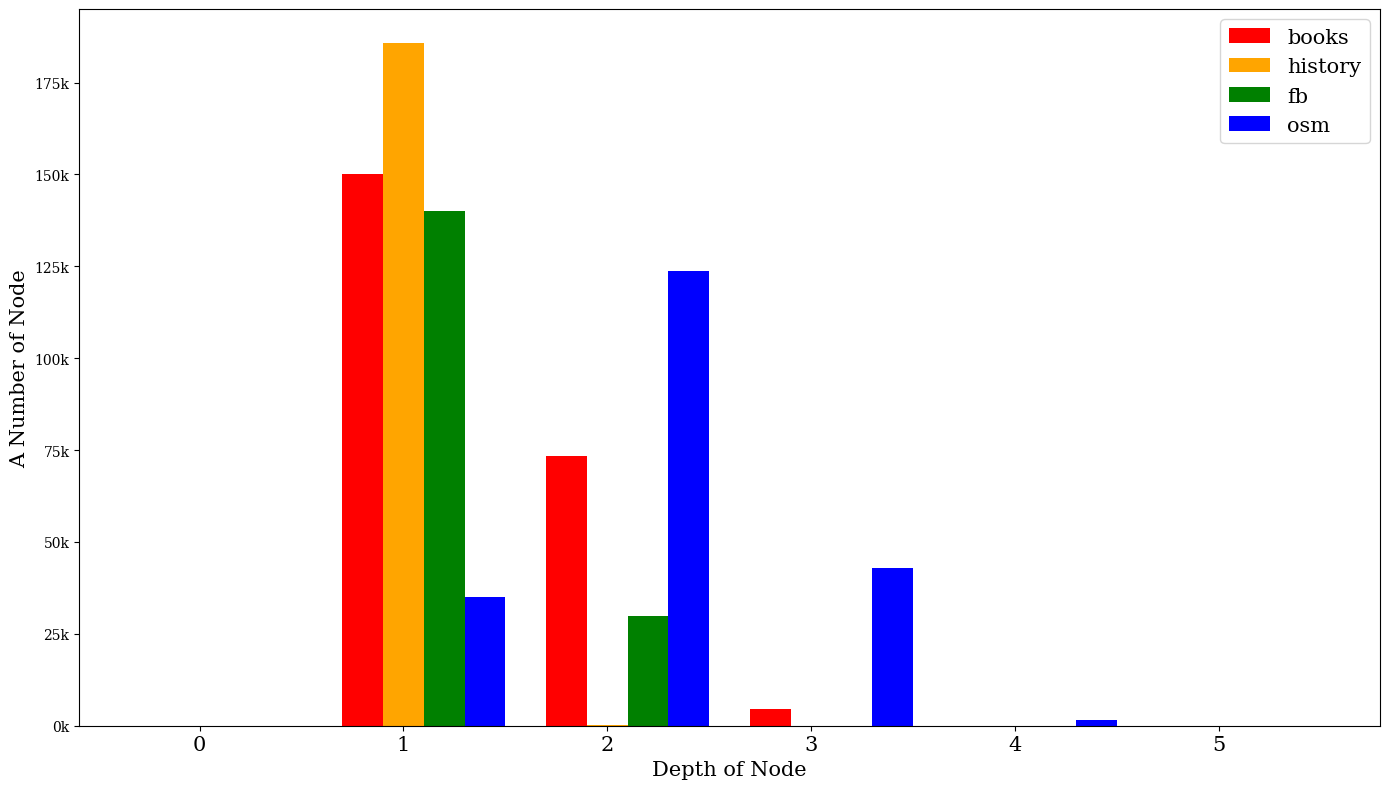

In [89]:
csv_file_names = [os.path.join(build_path, f'{dataset}.csv') for dataset in datasets]

# 각 파일의 데이터를 저장할 빈 DataFrame 생성
df_combined = pd.DataFrame()

# 각 파일에 대해 반복하여 데이터 처리
for i, file_name in enumerate(csv_file_names):
    df = pd.read_csv(file_name)
    # 'depth' 별로 개수를 계산하고 DataFrame으로 변환
    depth_counts = df['depth'].value_counts().sort_index().rename_axis('depth').reset_index(name=f'counts_{i}')
    # 병합된 DataFrame에 추가
    if df_combined.empty:
        df_combined = depth_counts
    else:
        df_combined = pd.merge(df_combined, depth_counts, on='depth', how='outer')

# NaN 값을 0으로 채움
df_combined.fillna(0, inplace=True)

# 그래프 그리기
plt.figure(figsize=(14, 8))
bar_width = 0.2  # 막대 너비
indices = np.arange(len(df_combined['depth']))  # depth 값의 개수에 따른 인덱스 배열

for i in range(len(csv_file_names)):
    plt.bar(indices + i * bar_width, df_combined[f'counts_{i}'], width=bar_width, color=colors[i], label=datasets[i])

plt.xlabel('Depth of Node', fontsize=15)
plt.ylabel('A Number of Node', fontsize=15)
plt.title('', fontsize=15, fontweight='bold')
plt.xticks(indices + bar_width, df_combined['depth'], fontsize=15)

# y축 값을 K 단위로 설정
formatter = FuncFormatter(to_k)
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(fontsize=15)
plt.tight_layout()
plt.show()


/home/nk/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nk/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


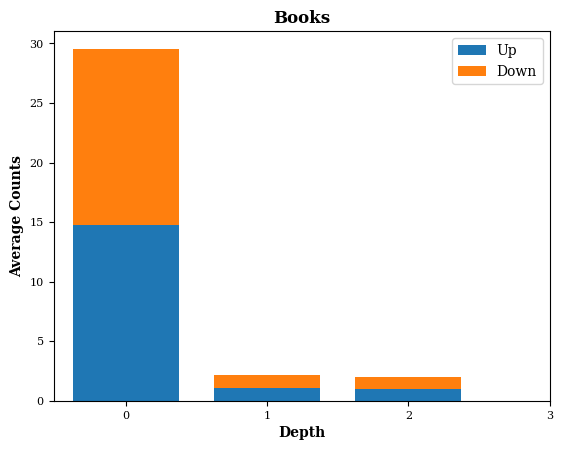

/home/nk/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nk/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


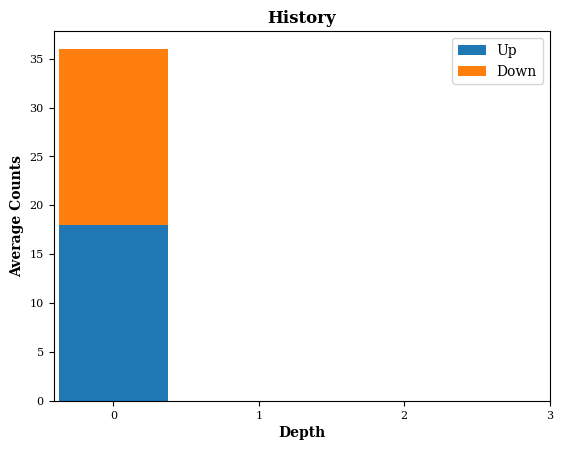

/home/nk/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nk/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


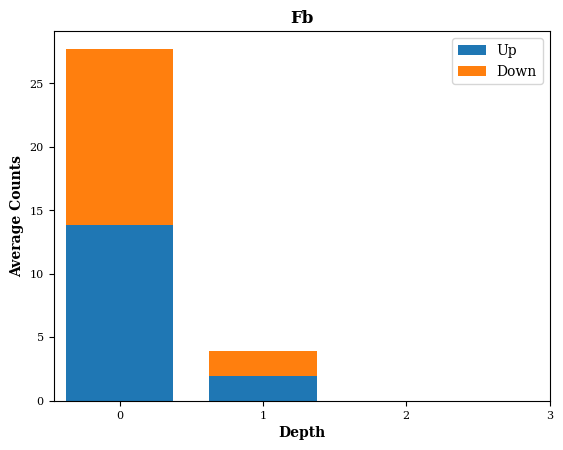

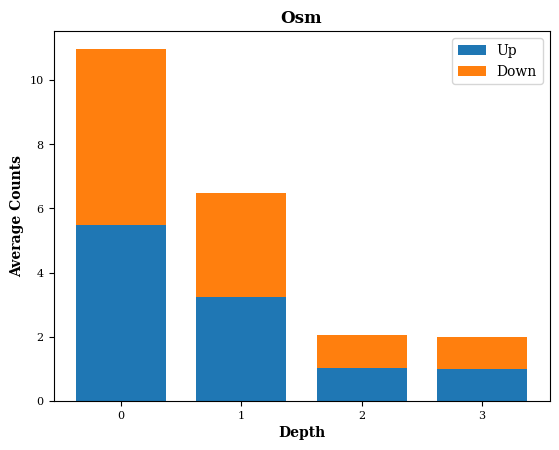

In [90]:
csv_file_names = [os.path.join(build_path, f'{dataset}_count.csv') for dataset in datasets]

all_depths = set()

for file_name in csv_file_names:
    df = pd.read_csv(file_name)
    for depth, _, _ in df.itertuples(index=False):
        try:
            int(depth)
            all_depths.add(depth)
        except ValueError:
            continue
    
all_depths = sorted(all_depths)

for i, file_name in enumerate(csv_file_names):
    depth_data = {}
    df = pd.read_csv(file_name)
    
    for depth, up, down in df.itertuples(index=False):
        try:
            int(depth)
        except ValueError:
            continue
            
        if depth not in depth_data:
            depth_data[depth] = {'up': [], 'down': []}
        depth_data[depth]['up'].append(up)
        depth_data[depth]['down'].append(down)

    averages = {depth: {'up': np.mean(info['up']), 'down': np.mean(info['down'])} for depth in all_depths for info in [depth_data.get(depth, {'up': [], 'down': []})]}

    ups = [averages[depth]['up'] for depth in all_depths]
    downs = [averages[depth]['down'] for depth in all_depths]

    fig, ax = plt.subplots()
    bar_width = 0.3
    index = np.arange(len(all_depths)) * (bar_width + 0.1)

    bar1 = ax.bar(index, ups, bar_width, label='Up')
    bar2 = ax.bar(index, downs, bar_width, bottom=ups, label='Down')

    ax.set_xlabel('Depth', fontdict={'weight': 'bold'})
    ax.set_ylabel('Average Counts', fontdict={'weight': 'bold'})
    ax.set_title(datasets[i][:1].upper() + datasets[i][1:], fontdict={'size': 12, 'weight': 'bold'})
    ax.set_xticks(index)
    ax.set_xticklabels(all_depths, size=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.legend(loc='upper right')

    plt.show()

[books] Node changing avg =  44.686868686868685
[history] Node changing avg =  36.02020202020202
[fb] Node changing avg =  33.676767676767675
[osm] Node changing avg =  41.676767676767675


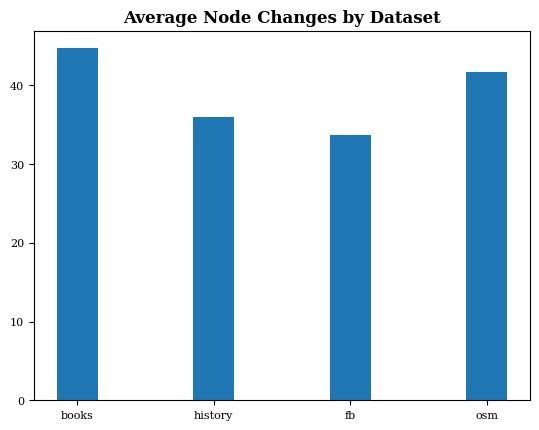

In [105]:
csv_file_names = [os.path.join(build_path, f'{dataset}_count.csv') for dataset in datasets]

averages = []

for i, file_name in enumerate(csv_file_names):
    idx = 0
    data = []
    df = pd.read_csv(file_name)
    
    for depth, up, down in df.itertuples(index=False):
        try:
            int(depth)
            if len(data) <= idx:
                data.append(up + down)
            else:
                data[idx] += up + down
        except ValueError:
            idx += 1
    
    avg = np.mean(data) if data else float('nan')
    averages.append(avg)
    print(f"[{datasets[i]}] Node changing avg = ", avg)

fig, ax = plt.subplots()
ax.bar(datasets, averages, 0.3)
ax.set_title('Average Node Changes by Dataset', fontdict={'weight': 'bold'})
ax.tick_params(labelsize=8)
plt.show()